In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip


## Downloading the files from kaggle competition

In [4]:
if not os.path.exists('train_data'):
    !unzip -q /kaggle/input/tgs-salt-identification-challenge/train.zip -d train_data

In [5]:
if not os.path.exists('test_data'):
    !unzip -q /kaggle/input/tgs-salt-identification-challenge/test.zip -d test_data


In [6]:

image_dir = '/kaggle/working/train_data/images'
mask_dir = '/kaggle/working/train_data/masks'

print(len(os.listdir(image_dir)))
print(len(os.listdir(mask_dir)))

4000
4000


## Imports

In [7]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import albumentations as A
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader

## Augmentations

In [8]:
RESIZE_SIZE = 202
FINAL_SIZE = 256
train_transform = A.Compose([
    # First, resize the image to 202x202
    A.Resize(height=RESIZE_SIZE, width=RESIZE_SIZE, p=1.0),
    # Pad the 202x202 to 256x256 in order for the pooling and upscaling from the
    # Unet to work properly 
    A.PadIfNeeded(min_height=FINAL_SIZE, min_width=FINAL_SIZE, p=1.0),
    # Apply one of 8 rand symmetries
    A.SquareSymmetry(p=1.0),
    # Image-only transforms
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(std_range=(0.1,0.2),p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std = (0.229,0.224,0.225)),
    A.ToTensorV2(),
])

val_transform = A.Compose([
    # Must apply the same to the validation transformation
    A.Resize(height=RESIZE_SIZE, width=RESIZE_SIZE, p=1.0),
    A.PadIfNeeded(min_height=FINAL_SIZE, min_width=FINAL_SIZE, p=1.0),
    A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
    A.ToTensorV2(),
])

## Define filenames

In [9]:
data_filenames = os.listdir(image_dir)
#train_filenames, val_filenames = train_test_split(data_filenames,test_size = 0.2, random_state = 42)


(101, 101) (101, 101)


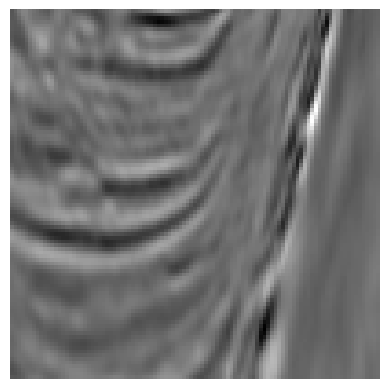

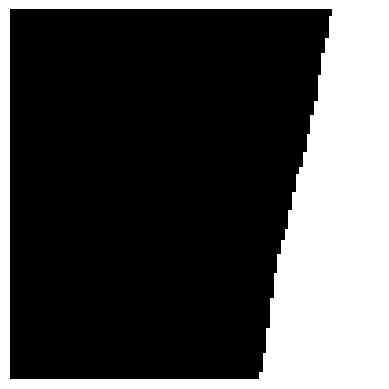

In [10]:
image_mask = Image.open(os.path.join(mask_dir,data_filenames[5])).convert('L')
image = Image.open(os.path.join(image_dir,data_filenames[5])).convert('L')

image_np = np.array(image)
mask_np = np.array(image_mask)
print(image_np.shape, mask_np.shape)

plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.show()
plt.imshow(image_mask, cmap = 'gray')
plt.axis('off')
plt.show()



In [11]:
augmented = train_transform(image = image_np, mask = mask_np)
augmented_image = augmented['image']
augmented_mask = augmented['mask']

print(f"Augmented image shape: {augmented_image.shape}, dtype: {augmented_image.dtype}")
print(f"Augmented mask shape: {augmented_mask.shape}, dtype: {augmented_mask.dtype}")
# I have to unsqueeze the mask so that it has the same shape as the image

Augmented image shape: torch.Size([1, 256, 256]), dtype: torch.float32
Augmented mask shape: torch.Size([256, 256]), dtype: torch.uint8


## Dataset

In [12]:
class SALTimagesdataset(Dataset):
    def __init__(self,image_dir, mask_dir, files, transform = None):
        self.image_paths = image_dir
        self.mask_paths = mask_dir
        self.files = files
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_name = self.files[idx]
        image_path = os.path.join(self.image_paths,image_name)
        # Read the images
        image = cv2.imread(image_path)
        # Even though the images are grey scale, they must be converted to 
        # rgb because I will be using a pretrained model that was trained on rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # The mask should remain a grayscale as there is no need for rgb

        if self.mask_paths is not None:
                mask_path = os.path.join(self.mask_paths,image_name)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = mask / 255.0 # Normalize + convert to float32
        else:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)

        
        if self.mask_paths is not None:
            # For training and validation, return image and mask
            return image, mask
        else:
            # For testing, return the image and its ID for the submission file
            return image, image_name


## Visualizing augmentations

In [13]:
def overlay_mask(image, mask, alpha=0.5, color=(0, 1, 0)): # Green overlay
    # Convert mask to 3 channels if needed, ensure boolean type
    mask_overlay = np.zeros_like(image, dtype=np.uint8)
    # Create a color overlay where mask is > 0
    mask_overlay[mask > 0] = (np.array(color) * 255).astype(np.uint8)

    # Blend image and overlay
    overlayed_image = cv2.addWeighted(image, 1, mask_overlay, alpha, 0)
    return overlayed_image
    
def visualize_segmentation(dataset, idx = 0, samples = 3):
    # Make a copy of the transform list t omodify for visualization
    if isinstance(dataset.transform, A.Compose):
        vis_transform_list = [
            t for t in dataset.transform
            if not isinstance(t, (A.Normalize, A.ToTensorV2))
        ]
        vis_transform = A.Compose(vis_transform_list)
    else:
        print("Warning: Could not automatically strip Normalize/ToTensor for visualization.")
        vis_transform = dataset.transform

    figure, ax = plt.subplots(samples + 1, 2, figsize=(8, 4 * (samples + 1)))

    # --- Get the original image and mask --- #
    original_transform = dataset.transform
    dataset.transform = None # Temporarily disable for raw data access
    image, mask = dataset[idx]
    dataset.transform = original_transform # Restore

    # Display original
    ax[0, 0].imshow(image)
    ax[0, 0].set_title("Original Image")
    ax[0, 0].axis("off")
    #ax[0, 1].imshow(mask, cmap='gray') # Show mask directly
    #ax[0, 1].set_title("Original Mask")
    ax[0, 1].axis("off")
    ax[0, 1].imshow(overlay_mask(image, mask)) # Or show overlay
    ax[0, 1].set_title("Original Overlay")

    # --- Apply and display augmented versions --- #
    for i in range(samples):
        # Apply the visualization transform
        if vis_transform:
            augmented = vis_transform(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']
        else:
            aug_image, aug_mask = image, mask # Should not happen normally

        # Display augmented image and mask
        ax[i + 1, 0].imshow(aug_image)
        ax[i + 1, 0].set_title(f"Augmented Image {i+1}")
        ax[i + 1, 0].axis("off")

        #ax[i + 1, 1].imshow(aug_mask, cmap='gray') # Show mask directly
        #ax[i + 1, 1].set_title(f"Augmented Mask {i+1}")
        ax[i + 1, 1].axis("off")
        ax[i+1, 1].imshow(overlay_mask(aug_image, aug_mask)) # Or show overlay
        ax[i+1, 1].set_title(f"Augmented Overlay {i+1}")


    plt.tight_layout()
    plt.show()

In [14]:
# train_dataset = SALTimagesdataset(image_dir, mask_dir, train_filenames, transform = train_transform)
# val_dataset = SALTimagesdataset(image_dir, mask_dir, val_filenames, transform = val_transform)
# print(len(train_dataset))

# The whole dataset with train transformations
train_dataset_full = SALTimagesdataset(image_dir, mask_dir, data_filenames, transform = train_transform) 
# The whole dataset with val transformations
val_dataset_full = SALTimagesdataset(image_dir, mask_dir, data_filenames, transform = val_transform) 
print(len(val_dataset_full))
print(len(data_filenames))

4000
4000


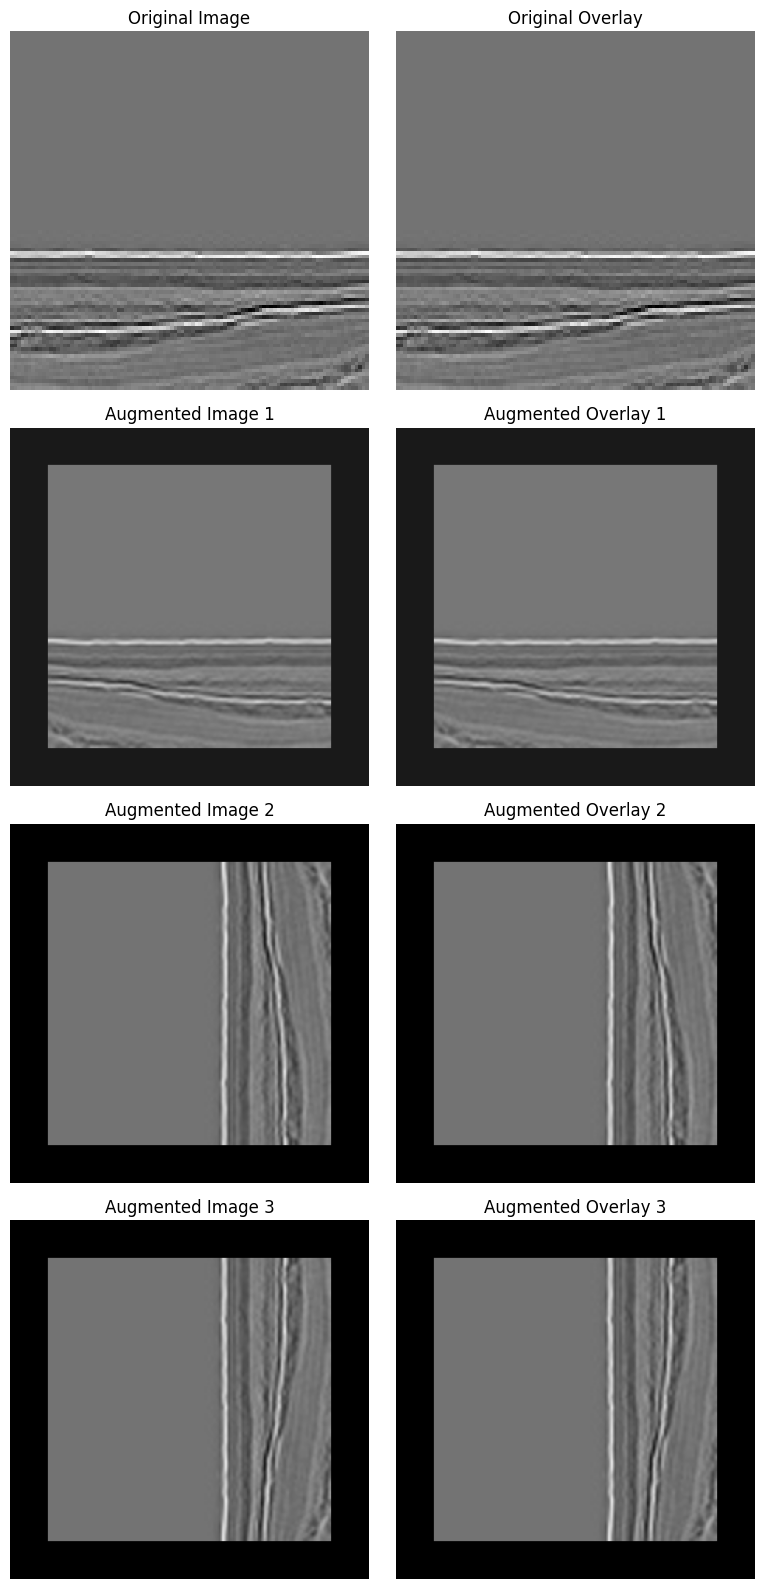

In [15]:
visualize_segmentation(train_dataset_full)

## Define base model

This cell previously contained the data loader, before I used a K-fold model

In [16]:
# Use 4 workers because the CPU from Kaggle Notebook has 4 cores
# train_loader =  DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 4)
# val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 4)

I will use ResNet34 as a pretrained model for the encoder 

In [17]:
try:
    # Try to import the library
    import segmentation_models_pytorch as smp
    print("segmentation_models_pytorch is already installed.")
except ImportError:
    # If it fails, run the installation
    print("Installing segmentation_models_pytorch...")
    !pip install -q segmentation_models_pytorch
    print("Installation complete.")
    import segmentation_models_pytorch as smp

segmentation_models_pytorch is already installed.


In [18]:
def get_base_efficientnetb4_model():
    model = smp.Unet(
        encoder_name = "efficientnet-b4",
        encoder_weights = "imagenet",
        in_channels = 3,
        classes = 1,
    )
    return model


## Training the model + auxiliary functions

In [19]:
def calculate_iou(pred_mask, true_mask, salt_pred_threshold = 0.5):
    pred_mask_binary = (pred_mask > salt_pred_threshold).float()

    # Handle the cases where one of the masks doesn't have any salt pixels
    is_true_empty = true_mask.sum() == 0
    is_pred_empty = pred_mask_binary.sum() == 0

    if is_true_empty and is_pred_empty:
        return 1.0  # Correctly predicted empty mask
    if is_true_empty and not is_pred_empty:
        return 0.0  # False positive: predicted salt where there is none
    if not is_true_empty and is_pred_empty:
        return 0.0  # False negative: missed salt that was present

    intersection = (pred_mask_binary * true_mask).sum()
    union = pred_mask_binary.sum() + true_mask.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)

    iou_thresholds = np.linspace(0.5,0.95,10) # Takes 10 values evenly spaced between 0,5 and 0,95
    
    # How many thresholds does the pred_mask pass
    hits = (iou.item() > iou_thresholds).sum()

    mean_iou = hits/len(iou_thresholds)

    return mean_iou
    

In [26]:
import copy
from torch.cuda.amp import GradScaler
from torch.amp import autocast 
def train_model(model, device, train_loader, val_loader, 
            loss_function, optimizer, scheduler, 
                num_epochs, one_cycle = False, patience = 15):
    history = {
        'train_loss':[],
        'val_loss':[],
        'train_iou':[],
        'val_iou':[],
        'lr':[]
    }

    scaler = torch.amp.GradScaler('cuda')
    
    epochs_no_improve = 0    
    best_model = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    for epoch in range(num_epochs):
        print("\n")
        print(f"Current Epoch:{epoch+1}/{num_epochs}")

        for phase in ['train','val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            running_loss = 0.0
            running_iou  = 0.0
    
            for images, masks in dataloader:
                images = images.to(device)
                masks = masks.to(device)
                # Set gradients to 0
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast(device_type='cuda'):
                        out = model(images)
                        predictions = torch.sigmoid(out)
                        loss = loss_function(out, masks)
                        
                    # If in training phase update gradients
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        
                        if one_cycle:
                            scheduler.step()
                            
                    running_loss += loss.item() * images.size(0)

                    for pred,mask in zip(predictions,masks):
                        running_iou += calculate_iou(pred, mask)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_iou / len(dataloader.dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_iou'].append(epoch_acc)
                history['lr'].append(optimizer.param_groups[0]['lr'])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_iou'].append(epoch_acc)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f} Lr:{optimizer.param_groups[0]['lr']:.2e}")

            if phase == 'val':
                if epoch_acc > best_iou:
                    print(f"Validation IoU improved from {best_iou:.4f} to {epoch_acc:.4f}. Saving model.")

                    best_iou = epoch_acc
                    best_model = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"Validation IoU didn't improve, Patience: {epochs_no_improve}/{patience}")
        if scheduler and not one_cycle:
            scheduler.step()
        
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break        
    print(f"Best validation accuracy:{best_iou}")
    model.load_state_dict(best_model)
    return model, history


                    

In [21]:
def plot_history(history):
    """
    Plots the training and validation loss, IoU, and learning rate.
    """
    # Create a 1x3 grid of subplots
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot loss
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss vs. Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)
    
    # Plot iou (accuracy)
    ax[1].plot(history['train_iou'], label='Train IoU')
    ax[1].plot(history['val_iou'], label='Validation IoU')
    ax[1].set_title('IoU vs. Epochs')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('IoU')
    ax[1].legend()
    ax[1].grid(True)
    
    # Plot lr
    ax[2].plot(history['lr'], label='Learning Rate')
    ax[2].set_title('Learning Rate vs. Epochs')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Learning Rate')
    ax[2].legend()
    ax[2].grid(True)
    plt.tight_layout()
    plt.show()


In [22]:
import os
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning, message='"is" with a literal. Did you mean "=="?')

file_name = "lovasz_losses.py"

if not os.path.exists(file_name):
    print("Downloading lovasz_losses.py...")
    # Use wget to download the  Python file from GitHub
    !wget -q https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
    print("Download complete.")
else:
    print(f"{file_name} already exists.")

from lovasz_losses import lovasz_hinge

lovasz_losses.py already exists.


In [23]:
dice_loss = smp.losses.DiceLoss(mode = 'binary')
bce_loss = nn.BCEWithLogitsLoss()

def bce_with_dice_loss(inputs, targets, weight_bce =0.5, weight_dice = 0.5):
    loss_bce = bce_loss(inputs,targets)
    loss_dice = dice_loss(inputs,targets)
    return (weight_bce * loss_bce) + (weight_dice * loss_dice)

In [24]:
from tqdm import tqdm
import cv2
import numpy as np
# I have to know the images that have no salt so that my 5 fold model will not be imbalanced
# as the images with no salt can negatively impact the performance of my model
y_stratify = []


print("Generating stratification labels")
for mask_path in tqdm(data_filenames):
    full_path = os.path.join(mask_dir, mask_path)
    mask = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)    
    if np.sum(mask) > 0:
        y_stratify.append(1)
    else:
        y_stratify.append(0)
y_stratify = np.array(y_stratify)

print(f"Stratification labels created. Found {np.sum(y_stratify)} salt masks.")

Generating stratification labels


100%|██████████| 4000/4000 [00:00<00:00, 9863.33it/s] 

Stratification labels created. Found 2438 salt masks.


cuda
Decoder only training: 



Current Epoch:1/50
train Loss: 0.5767 Accuracy: 0.1353 Lr:1.00e-04
val Loss: 0.4061 Accuracy: 0.2094 Lr:1.00e-04
Validation IoU improved from 0.0000 to 0.2094. Saving model.


Current Epoch:2/50
train Loss: 0.4061 Accuracy: 0.2288 Lr:9.99e-05
val Loss: 0.3222 Accuracy: 0.4289 Lr:9.99e-05
Validation IoU improved from 0.2094 to 0.4289. Saving model.


Current Epoch:3/50
train Loss: 0.3298 Accuracy: 0.3465 Lr:9.96e-05
val Loss: 0.2680 Accuracy: 0.5402 Lr:9.96e-05
Validation IoU improved from 0.4289 to 0.5402. Saving model.


Current Epoch:4/50
train Loss: 0.2896 Accuracy: 0.4004 Lr:9.92e-05
val Loss: 0.2317 Accuracy: 0.5688 Lr:9.92e-05
Validation IoU improved from 0.5402 to 0.5688. Saving model.


Current Epoch:5/50
train Loss: 0.2600 Accuracy: 0.4370 Lr:9.86e-05
val Loss: 0.2099 Accuracy: 0.5626 Lr:9.86e-05
Validation IoU didn't improve, Patience: 1/15


Current Epoch:6/50
train Loss: 0.2503 Accuracy: 0.4627 Lr:9.78e-05
val Loss: 0.1900 Accuracy: 0.5228 Lr

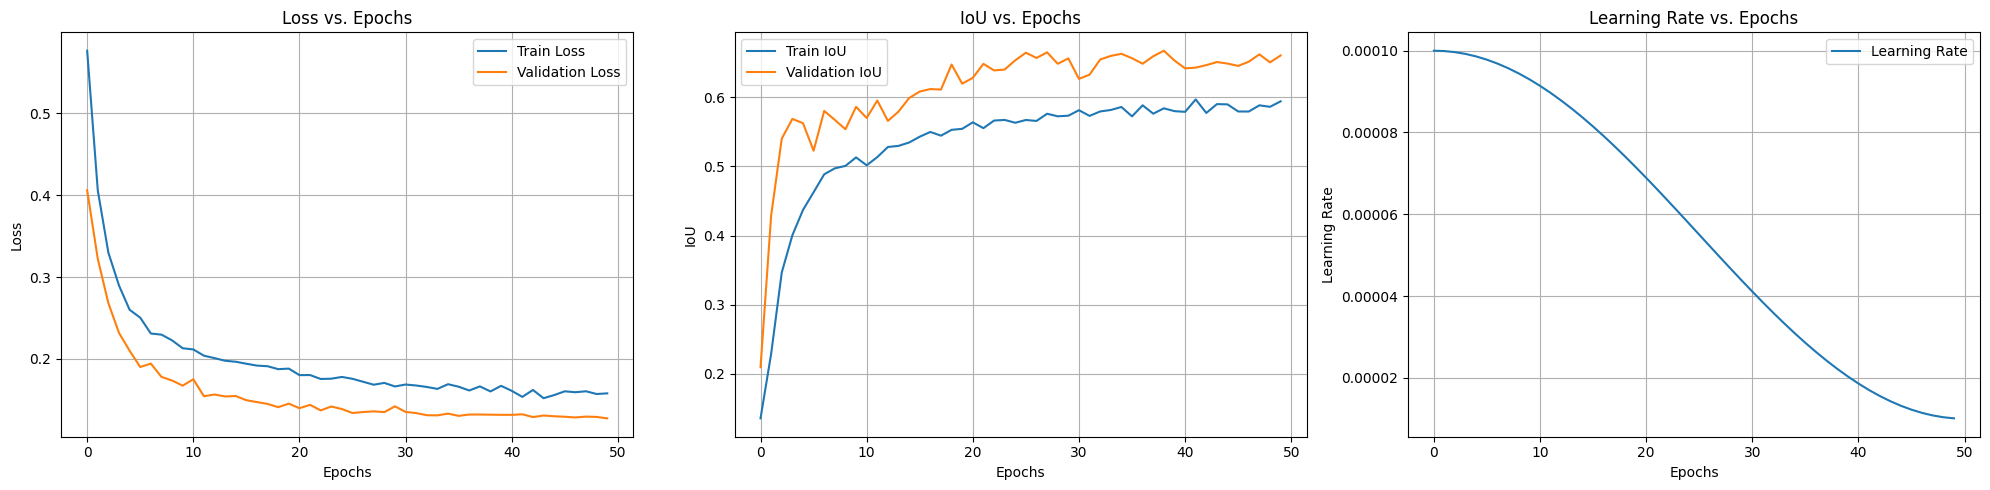

Full network training: 



Current Epoch:1/50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 1.2511 Accuracy: 0.6006 Lr:2.53e-06
val Loss: 0.9670 Accuracy: 0.6833 Lr:2.53e-06
Validation IoU improved from 0.0000 to 0.6833. Saving model.


Current Epoch:2/50
train Loss: 1.1546 Accuracy: 0.6207 Lr:4.08e-06
val Loss: 0.9232 Accuracy: 0.6870 Lr:4.08e-06
Validation IoU improved from 0.6833 to 0.6870. Saving model.


Current Epoch:3/50
train Loss: 1.0920 Accuracy: 0.6291 Lr:6.59e-06
val Loss: 0.8841 Accuracy: 0.6957 Lr:6.59e-06
Validation IoU improved from 0.6870 to 0.6957. Saving model.


Current Epoch:4/50
train Loss: 1.0303 Accuracy: 0.6314 Lr:9.95e-06
val Loss: 0.8155 Accuracy: 0.6972 Lr:9.95e-06
Validation IoU improved from 0.6957 to 0.6972. Saving model.


Current Epoch:5/50
train Loss: 0.9348 Accuracy: 0.6458 Lr:1.40e-05
val Loss: 0.7543 Accuracy: 0.6987 Lr:1.40e-05
Validation IoU improved from 0.6972 to 0.6987. Saving model.


Current Epoch:6/50
train Loss: 0.8656 Accuracy: 0.6456 Lr:1.86e-05
val Loss: 0.6907 Accuracy: 0.7052 Lr:1.86e-05
Validation IoU improved fr

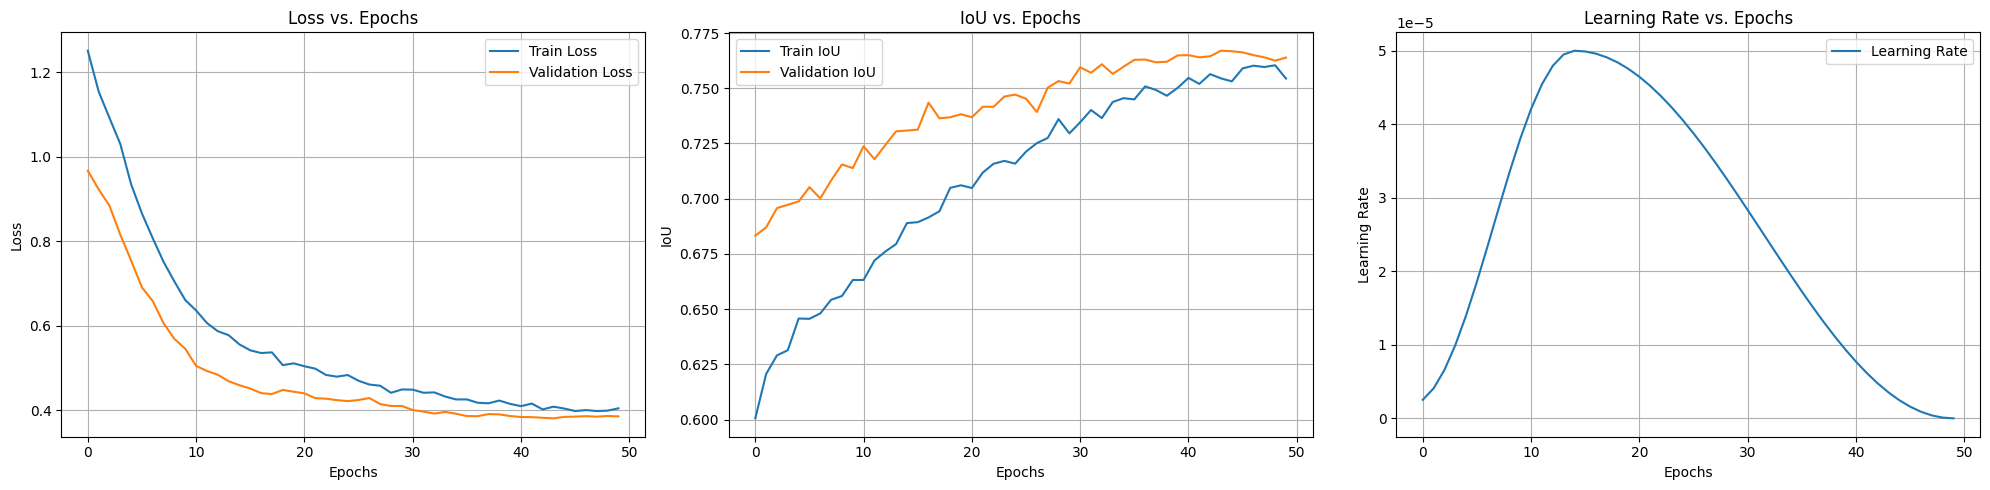

Saving results for fold 1
Fold 1 Best Score: 0.7670

Decoder only training: 



Current Epoch:1/50
train Loss: 0.7062 Accuracy: 0.0898 Lr:1.00e-04
val Loss: 0.5171 Accuracy: 0.1703 Lr:1.00e-04
Validation IoU improved from 0.0000 to 0.1703. Saving model.


Current Epoch:2/50
train Loss: 0.5067 Accuracy: 0.1705 Lr:9.99e-05
val Loss: 0.4014 Accuracy: 0.2108 Lr:9.99e-05
Validation IoU improved from 0.1703 to 0.2108. Saving model.


Current Epoch:3/50
train Loss: 0.4220 Accuracy: 0.2126 Lr:9.96e-05
val Loss: 0.3449 Accuracy: 0.4426 Lr:9.96e-05
Validation IoU improved from 0.2108 to 0.4426. Saving model.


Current Epoch:4/50
train Loss: 0.3583 Accuracy: 0.3382 Lr:9.92e-05
val Loss: 0.3071 Accuracy: 0.4717 Lr:9.92e-05
Validation IoU improved from 0.4426 to 0.4717. Saving model.


Current Epoch:5/50
train Loss: 0.3141 Accuracy: 0.3986 Lr:9.86e-05
val Loss: 0.2673 Accuracy: 0.4907 Lr:9.86e-05
Validation IoU improved from 0.4717 to 0.4907. Saving model.


Current Epoch:6/50
train Loss: 0.2888 Ac

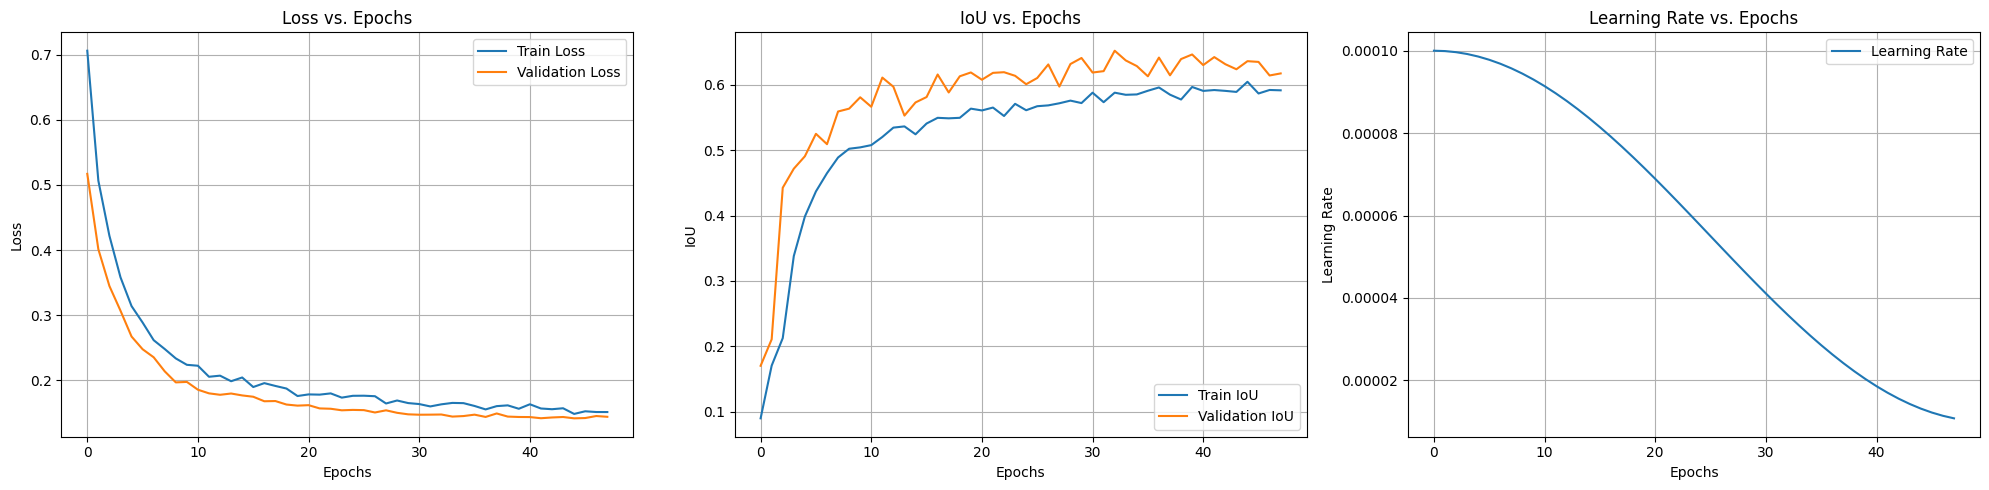

Full network training: 



Current Epoch:1/50
train Loss: 1.2163 Accuracy: 0.6118 Lr:2.53e-06
val Loss: 1.1102 Accuracy: 0.6625 Lr:2.53e-06
Validation IoU improved from 0.0000 to 0.6625. Saving model.


Current Epoch:2/50
train Loss: 1.1361 Accuracy: 0.6255 Lr:4.08e-06
val Loss: 1.0681 Accuracy: 0.6747 Lr:4.08e-06
Validation IoU improved from 0.6625 to 0.6747. Saving model.


Current Epoch:3/50
train Loss: 1.0619 Accuracy: 0.6378 Lr:6.59e-06
val Loss: 1.0049 Accuracy: 0.6805 Lr:6.59e-06
Validation IoU improved from 0.6747 to 0.6805. Saving model.


Current Epoch:4/50
train Loss: 1.0002 Accuracy: 0.6419 Lr:9.95e-06
val Loss: 0.9449 Accuracy: 0.6810 Lr:9.95e-06
Validation IoU improved from 0.6805 to 0.6810. Saving model.


Current Epoch:5/50
train Loss: 0.9262 Accuracy: 0.6468 Lr:1.40e-05
val Loss: 0.8767 Accuracy: 0.6789 Lr:1.40e-05
Validation IoU didn't improve, Patience: 1/15


Current Epoch:6/50
train Loss: 0.8570 Accuracy: 0.6485 Lr:1.86e-05
val Loss: 0.8156 Accuracy: 0.6841 Lr:1.86

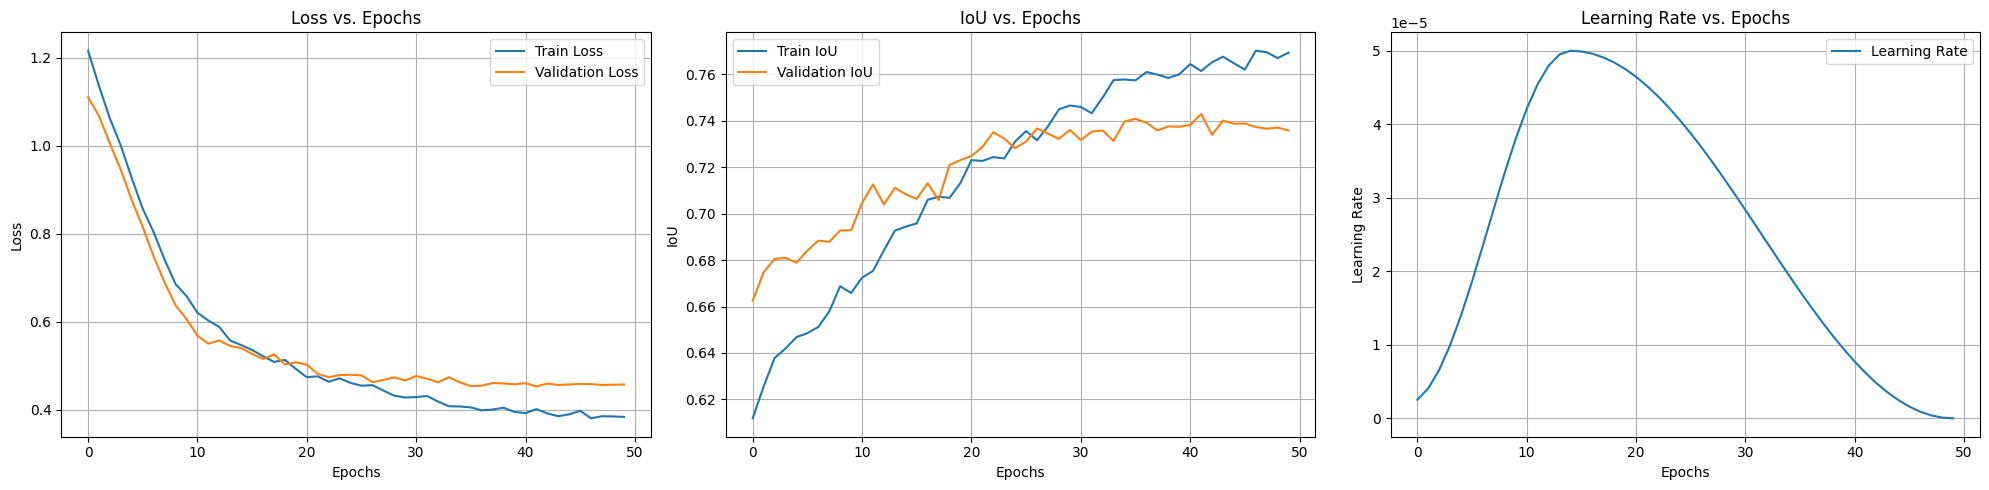

Saving results for fold 2
Fold 2 Best Score: 0.7430

Decoder only training: 



Current Epoch:1/50
train Loss: 0.5764 Accuracy: 0.1057 Lr:1.00e-04
val Loss: 0.3910 Accuracy: 0.2258 Lr:1.00e-04
Validation IoU improved from 0.0000 to 0.2258. Saving model.


Current Epoch:2/50
train Loss: 0.3991 Accuracy: 0.2327 Lr:9.99e-05
val Loss: 0.3165 Accuracy: 0.4727 Lr:9.99e-05
Validation IoU improved from 0.2258 to 0.4727. Saving model.


Current Epoch:3/50
train Loss: 0.3377 Accuracy: 0.3220 Lr:9.96e-05
val Loss: 0.2671 Accuracy: 0.4527 Lr:9.96e-05
Validation IoU didn't improve, Patience: 1/15


Current Epoch:4/50
train Loss: 0.3027 Accuracy: 0.3811 Lr:9.92e-05
val Loss: 0.2320 Accuracy: 0.5297 Lr:9.92e-05
Validation IoU improved from 0.4727 to 0.5297. Saving model.


Current Epoch:5/50
train Loss: 0.2798 Accuracy: 0.4034 Lr:9.86e-05
val Loss: 0.2109 Accuracy: 0.5756 Lr:9.86e-05
Validation IoU improved from 0.5297 to 0.5756. Saving model.


Current Epoch:6/50
train Loss: 0.2609 Accuracy: 0.4272 

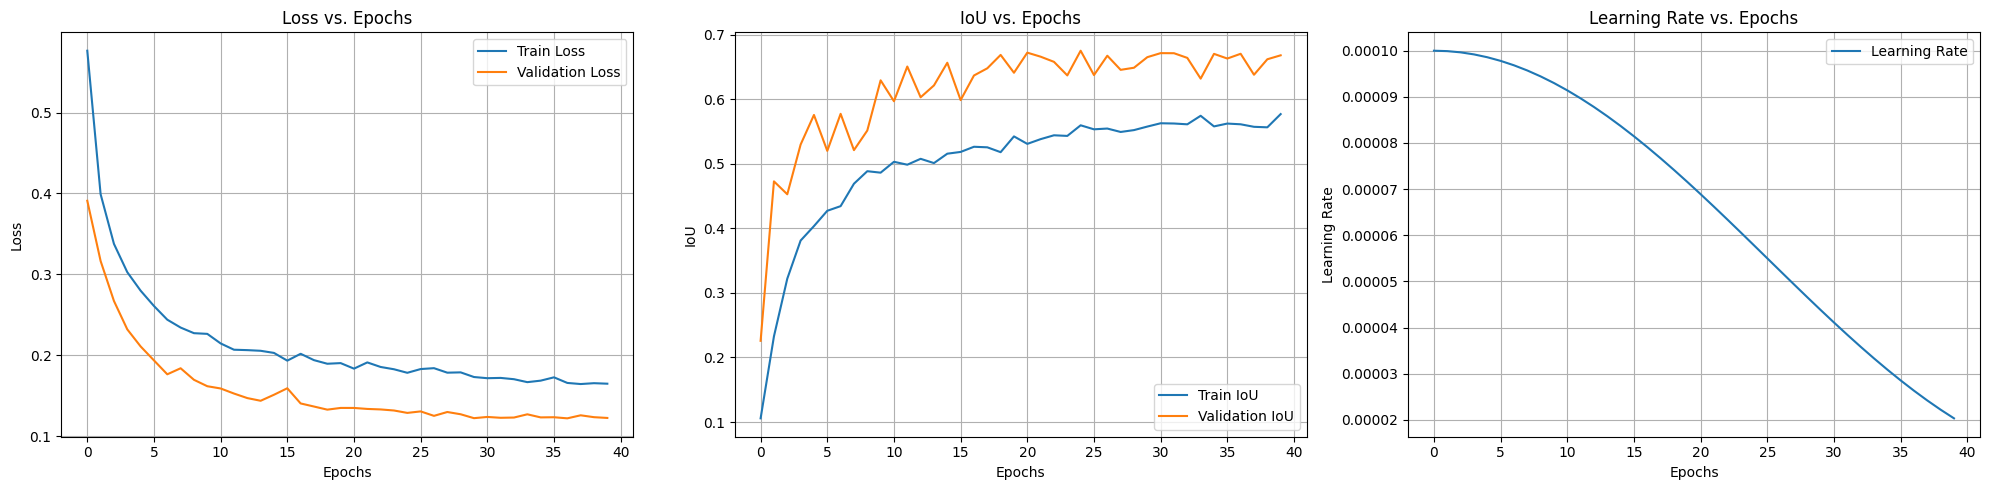

Full network training: 



Current Epoch:1/50
train Loss: 1.2918 Accuracy: 0.5743 Lr:2.53e-06
val Loss: 0.9335 Accuracy: 0.6929 Lr:2.53e-06
Validation IoU improved from 0.0000 to 0.6929. Saving model.


Current Epoch:2/50
train Loss: 1.2397 Accuracy: 0.5840 Lr:4.08e-06
val Loss: 0.8872 Accuracy: 0.6987 Lr:4.08e-06
Validation IoU improved from 0.6929 to 0.6987. Saving model.


Current Epoch:3/50
train Loss: 1.1610 Accuracy: 0.6040 Lr:6.59e-06
val Loss: 0.8286 Accuracy: 0.7024 Lr:6.59e-06
Validation IoU improved from 0.6987 to 0.7024. Saving model.


Current Epoch:4/50
train Loss: 1.0482 Accuracy: 0.6198 Lr:9.95e-06
val Loss: 0.7616 Accuracy: 0.7066 Lr:9.95e-06
Validation IoU improved from 0.7024 to 0.7066. Saving model.


Current Epoch:5/50
train Loss: 0.9806 Accuracy: 0.6216 Lr:1.40e-05
val Loss: 0.7138 Accuracy: 0.7094 Lr:1.40e-05
Validation IoU improved from 0.7066 to 0.7094. Saving model.


Current Epoch:6/50
train Loss: 0.8976 Accuracy: 0.6279 Lr:1.86e-05
val Loss: 0.6626 Accuracy:

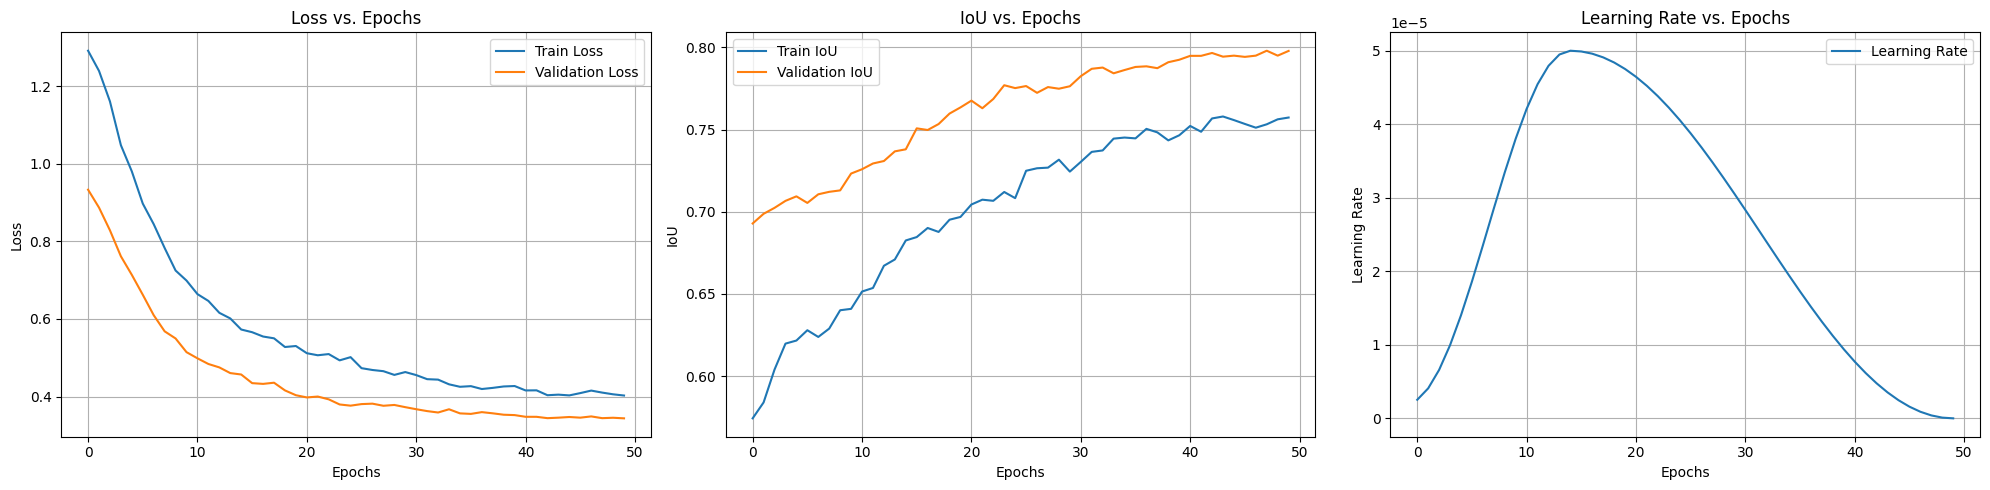

Saving results for fold 3
Fold 3 Best Score: 0.7980

Decoder only training: 



Current Epoch:1/50
train Loss: 0.7335 Accuracy: 0.0957 Lr:1.00e-04
val Loss: 0.5539 Accuracy: 0.1990 Lr:1.00e-04
Validation IoU improved from 0.0000 to 0.1990. Saving model.


Current Epoch:2/50
train Loss: 0.5295 Accuracy: 0.2144 Lr:9.99e-05
val Loss: 0.4363 Accuracy: 0.3495 Lr:9.99e-05
Validation IoU improved from 0.1990 to 0.3495. Saving model.


Current Epoch:3/50
train Loss: 0.4373 Accuracy: 0.2967 Lr:9.96e-05
val Loss: 0.3564 Accuracy: 0.4307 Lr:9.96e-05
Validation IoU improved from 0.3495 to 0.4307. Saving model.


Current Epoch:4/50
train Loss: 0.3682 Accuracy: 0.3491 Lr:9.92e-05
val Loss: 0.3032 Accuracy: 0.4224 Lr:9.92e-05
Validation IoU didn't improve, Patience: 1/15


Current Epoch:5/50
train Loss: 0.3234 Accuracy: 0.4069 Lr:9.86e-05
val Loss: 0.2574 Accuracy: 0.5296 Lr:9.86e-05
Validation IoU improved from 0.4307 to 0.5296. Saving model.


Current Epoch:6/50
train Loss: 0.2951 Accuracy: 0.4265 

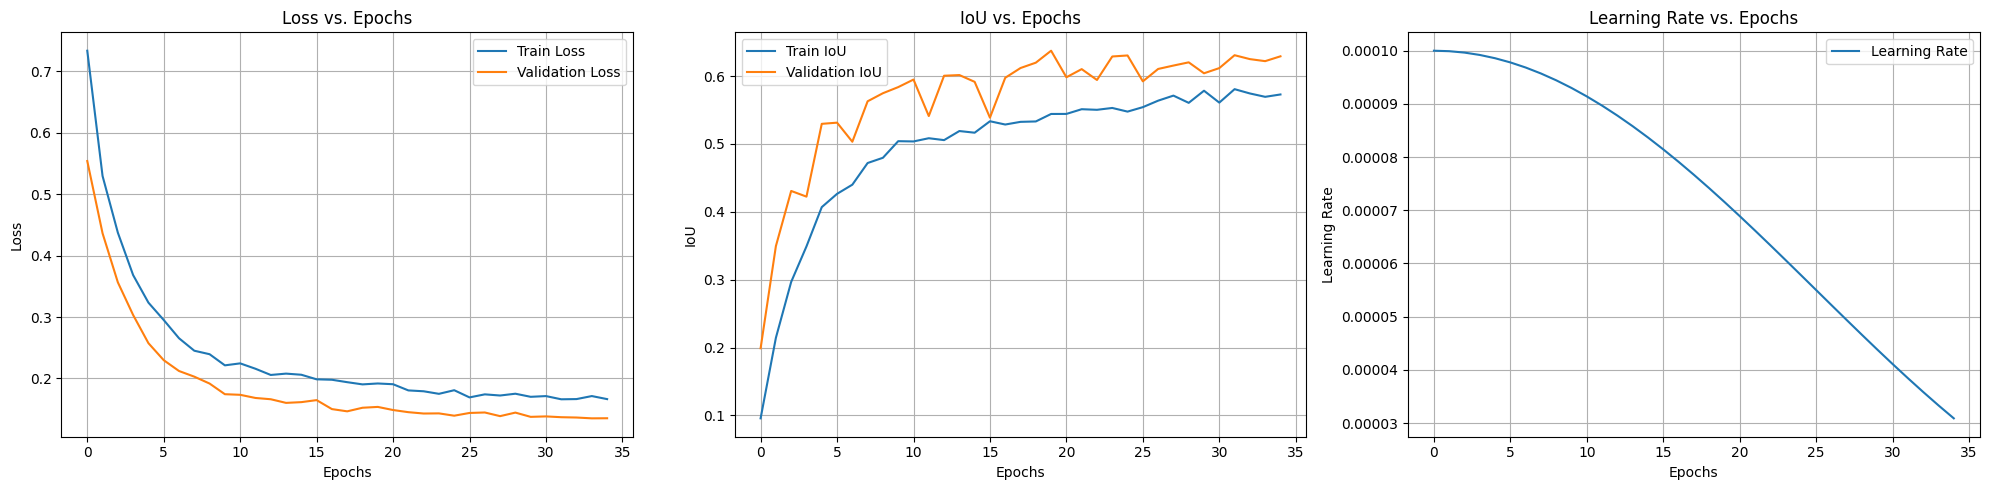

Full network training: 



Current Epoch:1/50
train Loss: 1.2080 Accuracy: 0.5893 Lr:2.53e-06
val Loss: 1.0258 Accuracy: 0.6677 Lr:2.53e-06
Validation IoU improved from 0.0000 to 0.6677. Saving model.


Current Epoch:2/50
train Loss: 1.1372 Accuracy: 0.6125 Lr:4.08e-06
val Loss: 0.9473 Accuracy: 0.6749 Lr:4.08e-06
Validation IoU improved from 0.6677 to 0.6749. Saving model.


Current Epoch:3/50
train Loss: 1.1084 Accuracy: 0.6063 Lr:6.59e-06
val Loss: 0.8909 Accuracy: 0.6774 Lr:6.59e-06
Validation IoU improved from 0.6749 to 0.6774. Saving model.


Current Epoch:4/50
train Loss: 0.9916 Accuracy: 0.6209 Lr:9.95e-06
val Loss: 0.8356 Accuracy: 0.6822 Lr:9.95e-06
Validation IoU improved from 0.6774 to 0.6822. Saving model.


Current Epoch:5/50
train Loss: 0.9299 Accuracy: 0.6204 Lr:1.40e-05
val Loss: 0.7553 Accuracy: 0.6824 Lr:1.40e-05
Validation IoU improved from 0.6822 to 0.6824. Saving model.


Current Epoch:6/50
train Loss: 0.8300 Accuracy: 0.6246 Lr:1.86e-05
val Loss: 0.6706 Accuracy:

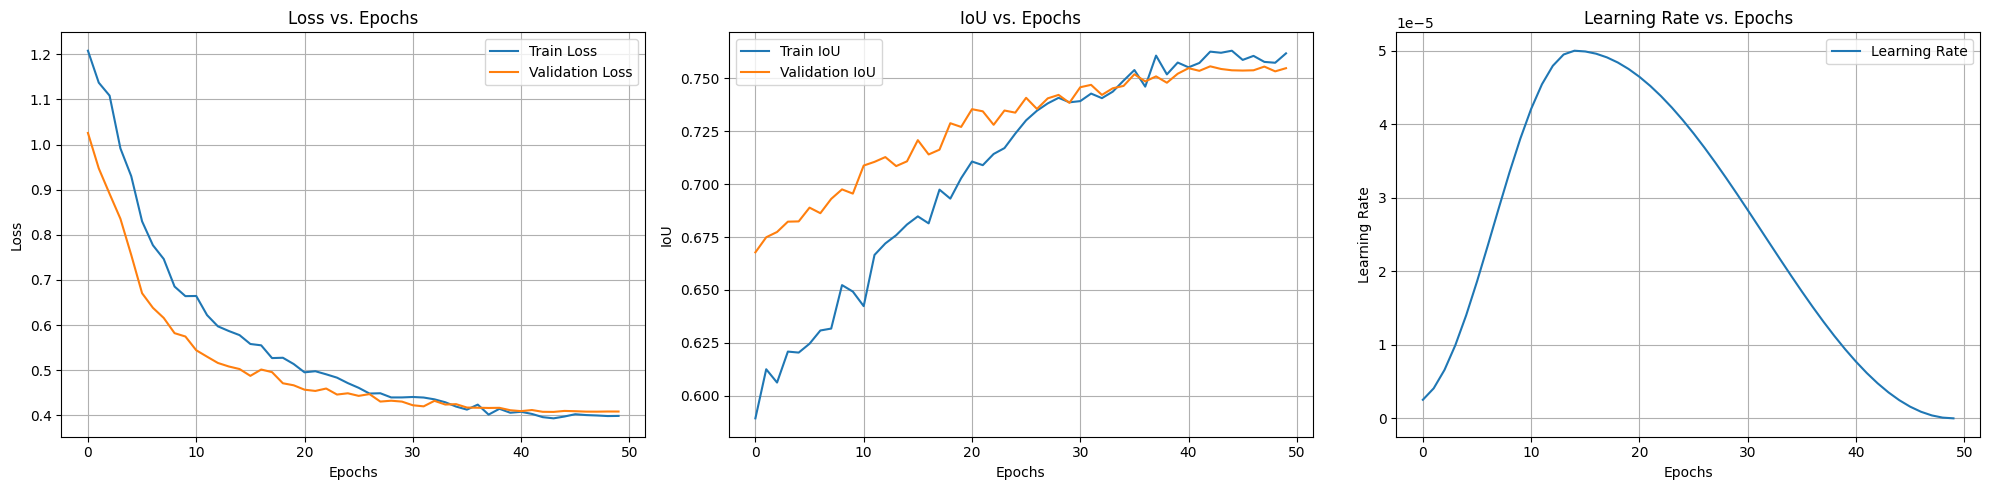

Saving results for fold 4
Fold 4 Best Score: 0.7556

Decoder only training: 



Current Epoch:1/50
train Loss: 0.5583 Accuracy: 0.1227 Lr:1.00e-04
val Loss: 0.4081 Accuracy: 0.1958 Lr:1.00e-04
Validation IoU improved from 0.0000 to 0.1958. Saving model.


Current Epoch:2/50
train Loss: 0.3790 Accuracy: 0.2491 Lr:9.99e-05
val Loss: 0.3056 Accuracy: 0.4388 Lr:9.99e-05
Validation IoU improved from 0.1958 to 0.4388. Saving model.


Current Epoch:3/50
train Loss: 0.3174 Accuracy: 0.3546 Lr:9.96e-05
val Loss: 0.2628 Accuracy: 0.4866 Lr:9.96e-05
Validation IoU improved from 0.4388 to 0.4866. Saving model.


Current Epoch:4/50
train Loss: 0.2838 Accuracy: 0.3911 Lr:9.92e-05
val Loss: 0.2304 Accuracy: 0.5639 Lr:9.92e-05
Validation IoU improved from 0.4866 to 0.5639. Saving model.


Current Epoch:5/50
train Loss: 0.2621 Accuracy: 0.4371 Lr:9.86e-05
val Loss: 0.2042 Accuracy: 0.5609 Lr:9.86e-05
Validation IoU didn't improve, Patience: 1/15


Current Epoch:6/50
train Loss: 0.2464 Accuracy: 0.4483 

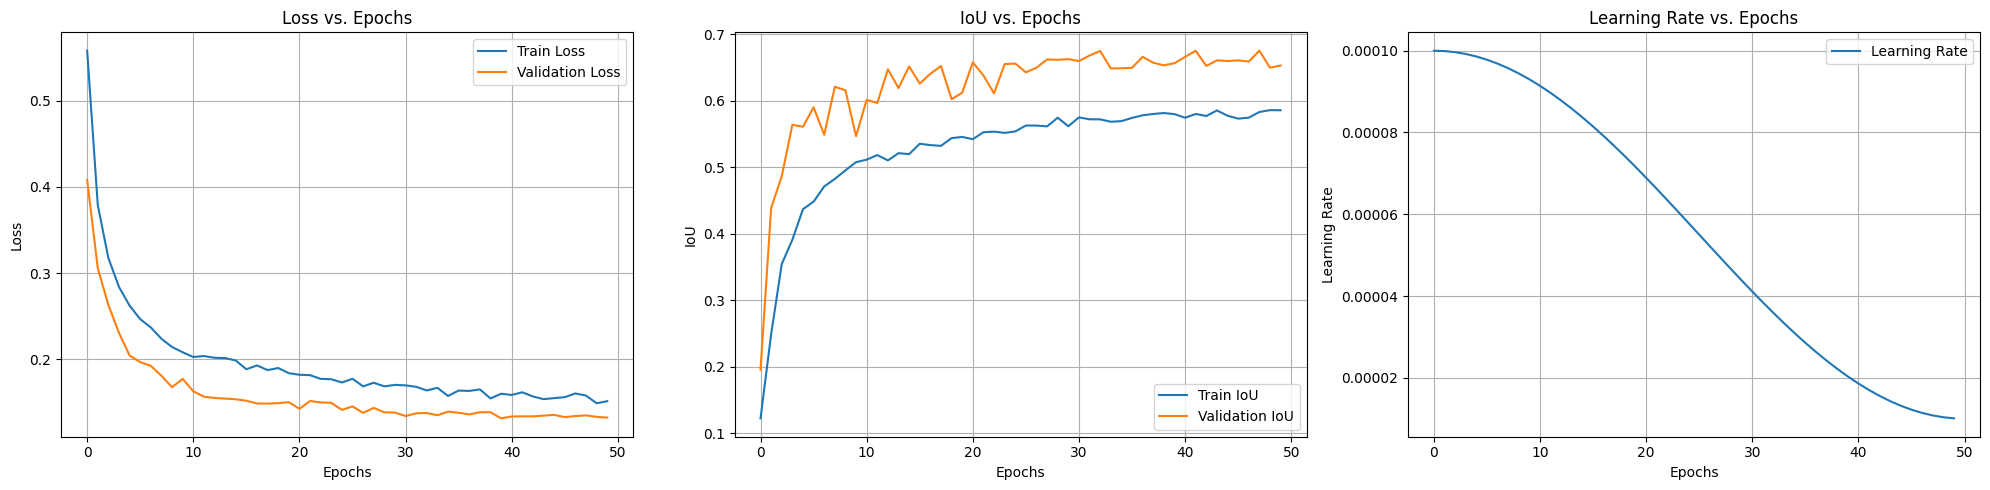

Full network training: 



Current Epoch:1/50
train Loss: 1.2168 Accuracy: 0.6016 Lr:2.53e-06
val Loss: 0.9667 Accuracy: 0.6930 Lr:2.53e-06
Validation IoU improved from 0.0000 to 0.6930. Saving model.


Current Epoch:2/50
train Loss: 1.1314 Accuracy: 0.6171 Lr:4.08e-06
val Loss: 0.9133 Accuracy: 0.7045 Lr:4.08e-06
Validation IoU improved from 0.6930 to 0.7045. Saving model.


Current Epoch:3/50
train Loss: 1.0262 Accuracy: 0.6408 Lr:6.59e-06
val Loss: 0.8243 Accuracy: 0.7061 Lr:6.59e-06
Validation IoU improved from 0.7045 to 0.7061. Saving model.


Current Epoch:4/50
train Loss: 0.9838 Accuracy: 0.6360 Lr:9.95e-06
val Loss: 0.7826 Accuracy: 0.7146 Lr:9.95e-06
Validation IoU improved from 0.7061 to 0.7146. Saving model.


Current Epoch:5/50
train Loss: 0.8968 Accuracy: 0.6409 Lr:1.40e-05
val Loss: 0.7120 Accuracy: 0.7179 Lr:1.40e-05
Validation IoU improved from 0.7146 to 0.7179. Saving model.


Current Epoch:6/50
train Loss: 0.8303 Accuracy: 0.6467 Lr:1.86e-05
val Loss: 0.6501 Accuracy:

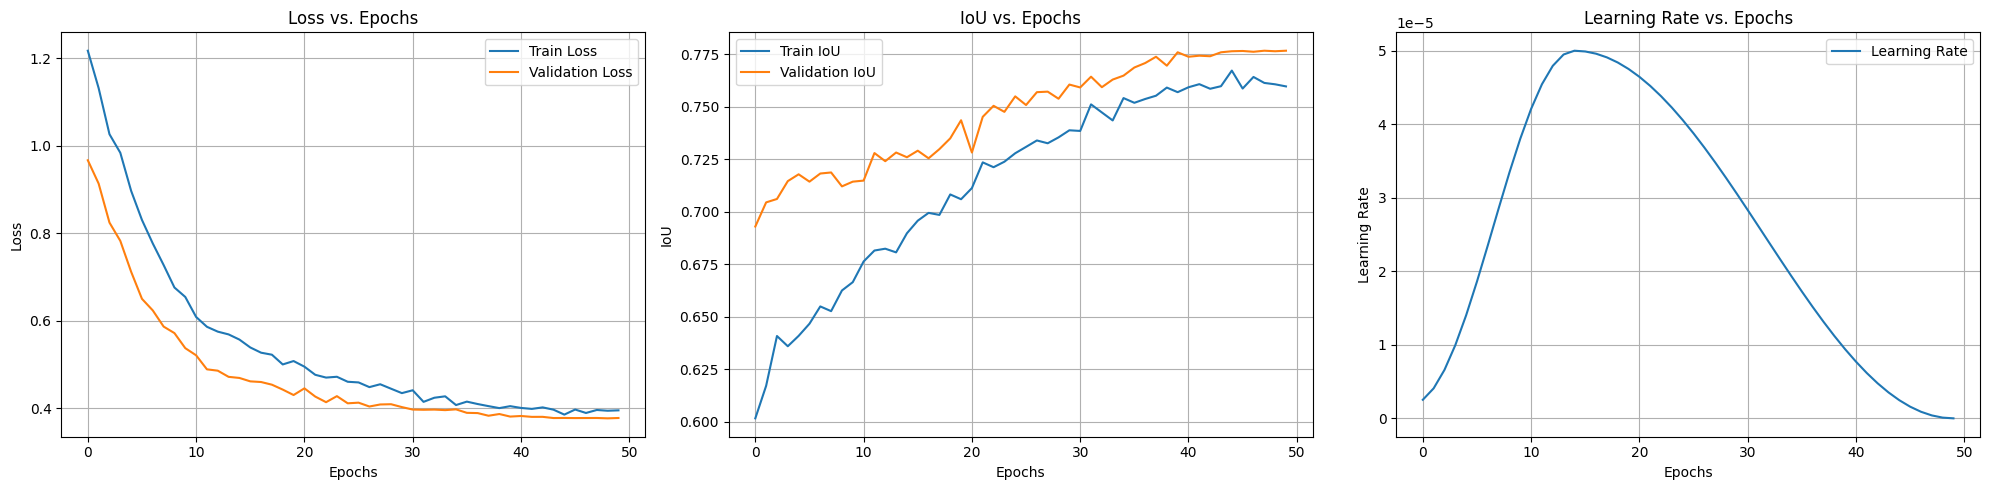

Saving results for fold 5
Fold 5 Best Score: 0.7767

SUMMARY: 
Average Score over 5 Folds: 0.7681 ± 0.0187


In [27]:
# First I will train only on the last layer of resnet34, then I will train on the decoder
# I will use a 5-fold model
from torch import optim
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import Subset

num_splits = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

skf = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = 42)

histories = []
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(data_filenames, y_stratify)):

    train_subset = Subset(train_dataset_full, train_idx)
    val_subset = Subset(val_dataset_full, val_idx)
    #print(len(train_subset), len(val_subset))
    train_loader = DataLoader(train_subset, batch_size = 32, shuffle = True,
                              num_workers = 4, pin_memory = True)
    val_loader = DataLoader(val_subset, batch_size =32, shuffle = False,
                            num_workers = 4, pin_memory = True)

    #print(len(train_loader),len(val_loader))
    
    model = get_base_efficientnetb4_model()

    model = model.to(device)
    
    print("Decoder only training: \n")
    
    # Freeze parameters 
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    learning_rate_decoder = 1e-4
    
    params_to_train = [param for param in model.parameters() if param.requires_grad == True]
    
    optimizer_decoder = optim.Adam(params_to_train,lr = learning_rate_decoder)
    
    scheduler_decoder = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_decoder,
    T_max = 50,
    eta_min = 1e-5,
)
    
    
    loss_function_decoder = bce_with_dice_loss
    
    decoder_best_model, decoder_history = train_model(model, device, train_loader, val_loader, loss_function_decoder,
                                              optimizer_decoder,
                                              scheduler_decoder,
                                              num_epochs = 50)
    plot_history(decoder_history)
    
    print("Full network training: \n")
    
    model.load_state_dict(decoder_best_model.state_dict())

    # Unfreeze the parameters from the encoder
    for param in model.parameters():
        param.requires_grad = True
    
    learning_rate_full = 5e-5
    
    
    optimizer_full = optim.Adam(model.parameters(), lr = learning_rate_full)
    
    scheduler_full = torch.optim.lr_scheduler.OneCycleLR(
        optimizer_full,
        max_lr=learning_rate_full,
        steps_per_epoch=len(train_loader), # Number of batches in the training loader
        epochs=50,
        pct_start=0.3, # Use 30% of steps for the warm-up phase
    )
    
    loss_function_full = lovasz_hinge
    
    
    full_best_model, full_history = train_model(model, device, train_loader, val_loader, loss_function_full,
                                           optimizer_full,
                                           scheduler_full,
                                           num_epochs = 50,
                                          one_cycle = True)
    plot_history(full_history)

    print(f"Saving results for fold {fold+1}")
    best_fold_score = max(full_history['val_iou'])
    fold_scores.append(best_fold_score)

    torch.save(full_best_model.state_dict(),f"best_model_fold{fold+1}.pth")

    print(f"Fold {fold + 1} Best Score: {best_fold_score:.4f}\n")


print("SUMMARY: ")
mean_score = np.mean(fold_scores)
std_score = np.std(fold_scores)
print(f"Average Score over {num_splits} Folds: {mean_score:.4f} ± {std_score:.4f}")


In [28]:
models = []
num_splits = 5

for fold in range(num_splits):
    # Create a fresh model instance
    model = get_base_efficientnetb4_model()

    # Load the saved weights for the current fold
    model_path = f"best_model_fold{fold+1}.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.to(device)
    # Set the model to evaluation mode
    model.eval()
    models.append(model)

print(f"Loaded {len(models)} models for ensembling.")

Loaded 5 models for ensembling.


## Making predictions for the test data set

In [29]:
test_image_dir = '/kaggle/working/test_data/images'
test_filenames = os.listdir(test_image_dir)
test_dataset = SALTimagesdataset(test_image_dir, None, test_filenames, transform = val_transform)

In [ ]:
#torch.save(best_model.state_dict(), 'best_model_weights2.pth')


In [30]:
test_loader = DataLoader(test_dataset, batch_size =32, shuffle = False, num_workers = 4)
#best_model.eval()

In [31]:
from tqdm import tqdm
predictions = []
test_ids = []
with torch.no_grad():
    for images,ids in tqdm(test_loader, desc = "Predicting"):
        images = images.to(device, dtype = torch.float32)
        
        fold_probs = []
        for model in models:
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            fold_probs.append(probs)

        # Average the predictions
        avg_probs = torch.stack(fold_probs).mean(dim=0)

        #  Threshold the mean probabilities
        masks = (avg_probs.squeeze() > 0.5).cpu().numpy().astype(np.uint8)

        predictions.extend(list(masks))
        test_ids.extend(ids)

Predicting: 100%|██████████| 563/563 [10:49<00:00,  1.15s/it]


In [32]:
# Encodes a binary mask into an encoding string, the mask should be 2D numpy array
def rle_encode(mask):
    if np.sum(mask) == 0:
        return ""
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0],pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    runs[1::2]-=runs[::2]
    return ' '.join(str(x) for x in runs)


In [33]:
test_ids_clean = test_ids_clean = [os.path.splitext(name)[0] for name in test_ids]
# Define the original and padded sizes
ORIGINAL_SIZE = 101
RESIZED_SIZE = 202
PADDED_SIZE = 256 
# Calculate the slice boundaries
start = (PADDED_SIZE - RESIZED_SIZE) // 2
end = start + RESIZED_SIZE

rle_predictions = []
for p in predictions:
    # Crop the padded area to get the 202x202 mask
    cropped_mask = p[start:end, start:end]

    # Resize the cropped mask back to the original 101x101 size
    final_mask = cv2.resize(cropped_mask, (ORIGINAL_SIZE, ORIGINAL_SIZE), interpolation=cv2.INTER_LINEAR)

    # Encode the final mask
    rle_predictions.append(rle_encode(final_mask))

In [34]:
# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids_clean, # Name of the file
    'rle_mask': rle_predictions # The predicted salt patches
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully: submission.csv")

Submission file created successfully: submission.csv
